# Random Forest
In dit notebook zal het model Random Forest centraal staan. Hierbij worden er hard drives door het Random Forest model voorspeld.

## Libraries Importeren

In [18]:
import pandas as pd
import numpy as np
import pickle
import os
from os.path import exists

from sklearn import ensemble, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, precision_score, f1_score, recall_score)

from graphviz import Source

MODELNAME = "random_forest"

EXISTING_MODEL = exists(f'../models/{MODELNAME}.pkl')

os.environ["PATH"] += os.pathsep + 'D:/Program Files/Graphviz/bin/'

## Random Forest model

Het random forest model is een model gebruikt voor o.a. classificatie. Het is een verzameling van verschillende decision trees. Door gebruik te maken van bagging en feature randomness op deze decision trees wordt er een “forest” gecreeërd die bestaat uit meerdere trees die niet gecorreleerd zijn met elkaar. Deze forest is in de meeste gevallen meer accuraat dan één enkele tree

### Random Forest Classification

De eerste stap zal zijn het kunnen predicten of een drive een failure heeft of niet aan de hand van de SMART-waardes. Deze SMART-waardes zijn 5, 9, 187, 188, 194, 197 en 198. Hiervoor is de Random Forest classification het beste doordat we te maken hebben met een boolean prediction value (het is een failure of geen failure).

### Data importeren
De data die gebruikt wordt is de data die gegenereerd is in het notebook `2 - sample analysing` (de dataset zonder 100% NaN waardes).

In [6]:
sample = pd.read_csv('../data/sample_without_100nan.csv')

### Data Cleaning
In de huidige dataset zitten er nog een aantal kolommen die geen toegevoegde waarde hebben voor het predicten van de failure. Deze kolommen zijn datum, model en serienummer. Hierdoor zullen deze eruit gehaald worden. Om toch de originele dataset later te kunnen gebruiken is er een keuze gemaakt om eerst een kopie te maken en daarmee verder te gaan.

In [7]:
copy_sample = sample.copy()

In [8]:
del copy_sample['date']
del copy_sample['serial_number']
del copy_sample['model']

Een ander gedeelte van het cleanen van data is het opvullen van lege waardes of het verwijderen van rows waar lege waardes in zitten. In 2 - sample analysing is te zien dat her percentage van lege waardes voor alle modellen minder dan 1% is. Hierdoor is er een keuze gemaakt om de rijen te verwijderen.

In [9]:
copy_sample.shape

(22008389, 8)

In [10]:
assert isinstance(copy_sample, pd.DataFrame), "df needs to be a pd.DataFrame"
copy_sample.dropna(inplace=True)
indices_to_keep = ~copy_sample.isin([np.nan, np.inf, -np.inf]).any(1)
copy_sample[indices_to_keep].astype(np.float64)

,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_194_raw,smart_197_raw,smart_198_raw
0,0.0,0.0,35462.0,0.0,0.0,22.0,0.0,0.0
1,0.0,0.0,12494.0,0.0,0.0,28.0,0.0,0.0
2,0.0,0.0,9544.0,0.0,0.0,29.0,0.0,0.0
3,0.0,0.0,13098.0,0.0,0.0,25.0,0.0,0.0
4,0.0,0.0,23427.0,0.0,0.0,32.0,0.0,0.0
...,...,...,...,...,...,...,...,...
22008384,0.0,0.0,1142.0,0.0,0.0,33.0,0.0,0.0
22008385,0.0,8.0,39697.0,0.0,0.0,24.0,0.0,0.0
22008386,0.0,0.0,1223.0,0.0,0.0,20.0,0.0,0.0
22008387,0.0,0.0,16158.0,0.0,0.0,21.0,0.0,0.0


Zoals hierboven en hieronder te zien was de shape eerst 22008389 en na het deleten van de rows 22002242. Dat is een verschil van ongeveer 6000 rows. Dat is niks op een dataset van 22 miljoen rows.

Daarnaast is al eerder aangegeven dat failure de kolom zal zijn die predict gaat worden. Hieronder wordt de failure op de Y axis gezet.

In [11]:
class_X = copy_sample.drop(['failure'], axis=1).values
class_Y = copy_sample['failure'].values

class_X.shape, class_Y.shape

((22002242, 7), (22002242,))

### Opsplitsen trainings- en validatieset
Voor het opsplitsen van de data in een trainingsset en in een validatieset gebruiken we `Scikit-learn`. Een model wordt gebruikt om te trainen, en de andere wordt gebruikt om te testen.

De data wordt opgesplit in een 80/20 split.

In [12]:
class_X_train, class_X_test, class_Y_train, class_Y_test = train_test_split(class_X, class_Y, test_size=0.2)

Daarna is nog een keer de shape te zien van zowel de Y als de X axis.

In [13]:
class_X_train.shape, class_Y_train.shape

((17601793, 7), (17601793,))

In [15]:
class_X_test.shape, class_Y_test.shape

((4400449, 7), (4400449,))

### Inladen testdataset
Dit stukje zal gaan over het testen van een andere dataset om te kijken of het werkt en of het model overfit is. Wanneer dit niet gebruikt wordt, dan zal dit stukje code gecomment zijn. Default is dit stukje code ook gecomment.

In [21]:
# sample_test = pd.read_csv('../data/sample2months2021.csv')

# del sample_test['date']
# del sample_test['serial_number']
# del sample_test['model']

# assert isinstance(copy_sample, pd.DataFrame), "df needs to be a pd.DataFrame"
# copy_sample.dropna(inplace=True)
# indices_to_keep = ~copy_sample.isin([np.nan, np.inf, -np.inf]).any(1)
# copy_sample[indices_to_keep].astype(np.float64)

# class_X_test = copy_sample.drop(['failure'], axis=1).values
# class_Y_test = copy_sample['failure'].values

### Trainen van het model
Hier wordt het model getrained. Dit wordt gedaan door middel van het Random Forest Classifier algoritme

Doordat het lang duurt om een model te trainen wordt het model opgeslagen zodat het meerdere keren gebruikt wordt. Dit wordt gedaan met pickle.

Als er al een random forest model bestaat, dan wordt dat model ingeladen in plaats van dat er weer een model getrained wordt.

In [4]:
if EXISTING_MODEL:
    rf_model = pickle.load(open(f'../models/{MODELNAME}.pkl', 'rb'))
else:
    rf_model = ensemble.RandomForestClassifier()
    rf_model.fit(class_X_train, class_Y_train)
    pickle.dump(rf_model, open("../models/random_forest.pkl", "wb"))

Met deze code kan het model weer geladen worden.

In [22]:
rf_Y_pred = rf_model.predict(class_X_test)

In [23]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(class_Y_test, rf_Y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(class_Y_test, rf_Y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(class_Y_test, rf_Y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(class_Y_test, rf_Y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.999985
Precision: 0.979592
Recall: 0.540084
F1 score: 0.696283


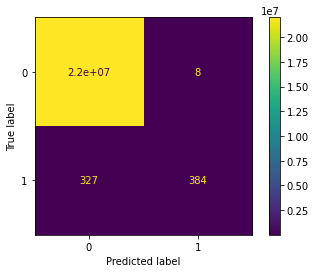

In [24]:
cm = confusion_matrix(class_Y_test, rf_Y_pred,
                      labels=rf_model.classes_)

ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=rf_model.classes_
).from_predictions(class_Y_test, rf_Y_pred)

In [7]:
rf_model.estimators_[0].tree_.node_count

2279

In [20]:
fn= ['smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw']

graph = Source( tree.export_graphviz(rf_model.estimators_[0], out_file=None, feature_names= fn))
graph.format = 'png'
graph.render('../images/dtree_render',view=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.57311 to fit


'..\\images\\dtree_render.png'